In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

# データの準備

### ステーションデータ

In [8]:
#ステーションデータ
station = pd.read_csv('/home/kyohei/bike_share_data/201608_station_data.csv')

station_SF = station[station['landmark']=='San Francisco']

#サンフランシスコに限定
station_SF_sub = station_SF[['station_id']]

In [238]:
#サンフランシスコのステーションID
station_id = station_SF_sub.station_id.astype(int)[:-2]

### トリップデータ

In [2]:
#トリップデータ
trip = pd.read_csv('/home/kyohei/bike_share_data/201608_trip_data.csv')

In [10]:
#tripデータをsanfransiscoに限定
trip_SF_start = trip.merge(station_SF_sub,left_on='Start Terminal',right_on='station_id')
trip_SF_end = trip.merge(station_SF_sub,left_on='End Terminal',right_on='station_id')

In [221]:
#スタートデータの変換
trip_SF_start['Start Date'] = trip_SF_start['Start Date'].apply(lambda x:pd.to_datetime(x))
trip_SF_start['start_time_hour'] = trip_SF_start['Start Date'].apply(lambda x:datetime.datetime(x.year,x.month,x.day,x.hour))

#エンドデータの変換
trip_SF_end['End Date'] = trip_SF_end['End Date'].apply(lambda x:pd.to_datetime(x))
trip_SF_end['end_time_hour'] = trip_SF_end['End Date'].apply(lambda x:datetime.datetime(x.year,x.month,x.day,x.hour))

### 天気データ

In [13]:
#天気データ
weather = pd.read_csv('/home/kyohei/bike_share_data/201608_weather_data.csv')

In [14]:
#dateの変換
weather['PDT'] = weather['PDT'].apply(lambda x:pd.to_datetime(x))

#カラムの表示を修正
weather.columns = weather.columns.str.strip()

#サンフランシスコのデータに限定
weather_SF = weather[weather.ZIP==95113]

In [242]:
#天気データの一部の変換
T_mapping = {'T':0}
f = lambda x:T_mapping.get(x,x)
weather_SF['PrecipitationIn'] = weather_SF.PrecipitationIn.map(f).astype(float)

/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [245]:
#weatherのダミー変数化
event_dummy = pd.get_dummies(weather_SF.Events)

weather_SF_mod = pd.concat([weather_SF,event_dummy],axis=1)

#いらないデータを落とす
weather_SF_sub = weather_SF_mod[['PDT','PrecipitationIn','CloudCover','Fog','Fog-Rain','Rain','Rain-Thunderstorm']]

#前日データ
weather_SF_sub_yesterday = pd.concat([weather_SF_sub[['PDT']],weather_SF_sub.shift(1).drop(['PDT'],axis=1)],axis=1).dropna()

### 関数の作成

In [247]:
#statusデータの変換
def status_translate(status):
    status['time'] = status['time'].apply(lambda x:pd.to_datetime(x))
    
    status['time'] = status['time'].apply(lambda x:datetime.datetime(x.year,x.month,x.day,x.hour))
    
    return status

### For文のスタート

In [337]:
scores = []
for number in station_id:
    folder = '/home/kyohei/bike_share/data_split_2015/San Francisco_station_status_stid%d.csv' %number
    status = pd.read_csv(folder)
    
    status = status_translate(status)
    
    #データの抽出
    trip_start_target = trip_SF_start[trip_SF_start['station_id']==number]
    
    trip_end_target = trip_SF_end[trip_SF_end['station_id']==number]
    
    #目的変数の作成
    target_start = pd.DataFrame(trip_start_target.groupby('start_time_hour').size()).reset_index()
    target_start.rename(columns={0:'count'},inplace=True)
    
    target_end = pd.DataFrame(trip_end_target.groupby('end_time_hour').size()).reset_index()
    target_end.rename(columns={0:'count'},inplace=True)
    
    #statusデータの手入れ
    #bikes_available,docks_availableが0になるかどうか
    status['bikes_available_0'] = (status['bikes_available']==0).astype(int)
    status['docks_available_0'] = (status['docks_available']==0).astype(int)
    
    #1時間のうちにavailable bikes,abailable docksが0になる回数、1回1分
    status_sub_bikes = pd.DataFrame(status.groupby(['time'])['bikes_available_0'].sum()).reset_index()
    status_sub_docks = pd.DataFrame(status.groupby(['time'])['docks_available_0'].sum()).reset_index()
    
    #statusのデータに曜日、時間を付加
    weekday = {0:'monday',1:'tuseday',2:'wednseday',3:'thursday',4:'friday',5:'saturday',6:'sunday'}
    
    status_sub_bikes['dayofweek'] = status_sub_bikes['time'].apply(lambda x:x.dayofweek)
    status_sub_bikes['dayofweek'] = status_sub_bikes['dayofweek'].map(weekday)
    
    status_sub_docks['dayofweek'] = status_sub_docks['time'].apply(lambda x:x.dayofweek)
    status_sub_docks['dayofweek'] = status_sub_docks['dayofweek'].map(weekday)
    
    status_sub_bikes['hour'] = status_sub_bikes['time'].apply(lambda x:x.hour)
    status_sub_docks['hour'] = status_sub_docks['time'].apply(lambda x:x.hour)
    
    ##status_sub_bikes['day'] = status_sub_bikes['time'].apply(lambda x:x.date())
    ##status_sub_docks['day'] = status_sub_docks['time'].apply(lambda x:x.date())
    
    #ダミー変数作成
    #時間
    dummy_hour_bikes = pd.get_dummies(status_sub_bikes.hour,prefix='time')
    dummy_hour_docks = pd.get_dummies(status_sub_docks.hour,prefix='time')
    
    #曜日
    dummy_weekday_bikes = pd.get_dummies(status_sub_bikes.dayofweek)
    dummy_weekday_docks = pd.get_dummies(status_sub_docks.dayofweek)
    
    #学習データの作成
    status_train_bikes = pd.concat([dummy_hour_bikes,dummy_weekday_bikes,status_sub_bikes[['time','bikes_available_0']]],axis=1).dropna()
    status_train_docks = pd.concat([dummy_hour_docks,dummy_weekday_docks,status_sub_docks[['time','docks_available_0']]],axis=1).dropna()
    
    #日付の付与
    status_train_bikes['day'] = status_train_bikes['time'].apply(lambda x:datetime.datetime(x.year,x.month,x.day))
    status_train_docks['day'] = status_train_docks['time'].apply(lambda x:datetime.datetime(x.year,x.month,x.day))
    
    
    data_bikes = status_train_bikes.merge(weather_SF_sub_yesterday,left_on='day',right_on='PDT',how='inner')
    data_docks = status_train_docks.merge(weather_SF_sub_yesterday,left_on='day',right_on='PDT',how='inner')
    
    data_comp_bikes = data_bikes.merge(target_start,left_on='time',right_on='start_time_hour',how='left')
    data_comp_docks = data_docks.merge(target_end,left_on='time',right_on='end_time_hour',how='left')
    
    data_comp_sub_bikes = data_comp_bikes.drop(['time','day','PDT','start_time_hour'],axis=1)
    data_comp_sub_docks = data_comp_docks.drop(['time','day','PDT','end_time_hour'],axis=1)
    
    data_comp_sub_bikes.fillna(0,inplace=True)
    data_comp_sub_docks.fillna(0,inplace=True)
    
    #学習データの完成
    data_comp_sub_bikes = data_comp_sub_bikes[data_comp_sub_bikes.bikes_available_0<10]
    data_comp_sub_docks = data_comp_sub_docks[data_comp_sub_docks.docks_available_0<10]
    
    
    y_bikes = data_comp_sub_bikes['count']
    X_bikes = data_comp_sub_bikes.drop('count',axis=1)
    
    y_docks = data_comp_sub_docks['count']
    X_docks = data_comp_sub_docks.drop('count',axis=1)
    
    X_bikes_train,X_bikes_test,y_bikes_train,y_bikes_test = train_test_split(X_bikes,y_bikes,random_state=0)
    X_docks_train,X_docks_test,y_docks_train,y_docks_test = train_test_split(X_docks,y_docks,random_state=0)
    
    #標準化
    std_bikes = StandardScaler()
    std_docks = StandardScaler()
    
    std_bikes.fit(X_bikes_train)
    X_bikes_train_std = std_bikes.transform(X_bikes_train)
    X_bikes_test_std = std_bikes.transform(X_bikes_test)
    
    std_docks.fit(X_docks_train)
    X_docks_train_std = std_docks.transform(X_docks_train)
    X_docks_test_std = std_docks.transform(X_docks_test)
    
    clf_bikes = RandomForestRegressor(n_estimators=20,n_jobs=-1)
    clf_docks = RandomForestRegressor(n_estimators=20,n_jobs=-1)
    
    clf_bikes.fit(X_bikes_train_std,y_bikes_train)
    clf_docks.fit(X_docks_train_std,y_docks_train)
    
    scores.append([number,
                   clf_bikes.score(X_bikes_train_std,y_bikes_train),
                   clf_bikes.score(X_bikes_test_std,y_bikes_test),
                   clf_docks.score(X_docks_train_std,y_docks_train),
                   clf_docks.score(X_docks_test_std,y_docks_test)
                  ])
    

In [340]:
scores = pd.DataFrame(scores)

In [341]:
scores.columns = ['station_id','lend_bikes_model_train','lend_bikes_model_test','return_bikes_model_train','return_bikes_model_test']

In [347]:
start_count = pd.DataFrame(trip_SF_start.groupby('Start Terminal').size()).reset_index()
end_count = pd.DataFrame(trip_SF_start.groupby('End Terminal').size()).reset_index()

In [349]:
start_count.rename(columns={0:'start_count'},inplace=True)
end_count.rename(columns={0:'end_count'},inplace=True)

In [350]:
count_merge = start_count.merge(end_count,left_on='Start Terminal',right_on='End Terminal')

In [352]:
scores_count_merge = scores.merge(count_merge,left_on='station_id',right_on='Start Terminal',how='inner')

In [367]:
a = scores_count_merge.drop(['Start Terminal','End Terminal'],axis=1)

In [368]:
a.to_excel('machine_laerning_result.xlsm',index=False)

([<matplotlib.axis.YTick at 0x7ff856f18c50>,
 <a list of 7 Text yticklabel objects>)

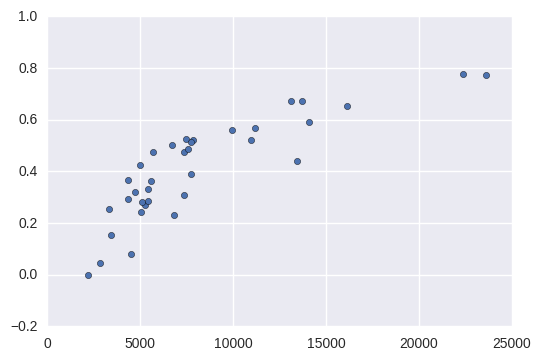

In [366]:
scores_count_merge.plot(y='lend_bikes_model_test',x='start_count',kind='scatter')
plt.xlabel('')
plt.ylabel('')
plt.ylim([-0.2,1.0])
plt.yticks([-0.2,0.0,0.2,0.4,0.6,0.8,1.0])

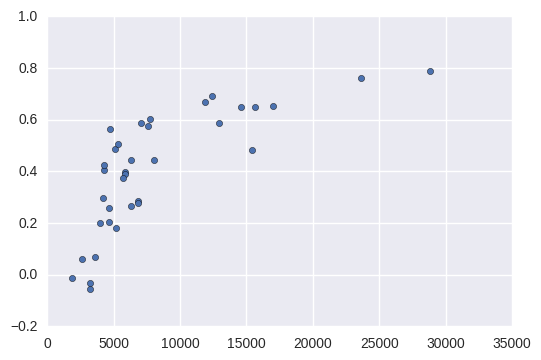

In [362]:
scores_count_merge.plot(y='return_bikes_model_test',x='end_count',kind='scatter')
plt.xlabel('')
plt.ylabel('')